#[1] Mount Google Drive

In [ ]:
from google.colab import drive
import os
import sys
drive.mount('/content/drive')

Mounted at /content/drive


#[2] Setting up Environment and Install Requirements

In [ ]:
%%capture
!pip install transformers
!pip install -r sources/ChinaFilm/requirements.txt
!apt-get update # to update ubuntu to correctly run apt install
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin
!pip install selenium
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')

In [ ]:
# Set Path
path_wd = '/content/drive/MyDrive/Github/Content'
os.chdir(path_wd)

# Import External Libs
import pandas as pd
import numpy as np
import datetime as dt
import re
import random

from IPython.display import display, HTML
import torch
from transformers import AdamW, BartForConditionalGeneration

import jieba.analyse
tfidf = jieba.analyse.extract_tags
textrank = jieba.analyse.textrank

In [ ]:
# Define Path
path_records = '/content/drive/MyDrive/Github/Content/tools/articles/records'

# [3] Load Release and Registration Records

In [ ]:
# Import Releases
path_releases = '/content/drive/MyDrive/Github/Content/sources/ChinaFilm/records/contents_of_releases.csv'
df_releases = pd.read_csv(path_releases, index_col=0, encoding='utf-8')

# Import Reg
path_regs = '/content/drive/MyDrive/Github/Content/sources/ChinaFilm/records/contents_of_registrations.json'
df_reg = pd.read_json(path_regs)
df_reg['匹配片名'] = df_reg['片名']

# Get Latest Issue
str_date_curr_release = df_releases.sort_values(by='公示日期', ascending=False).iloc[0]['公示日期']
dt_curr_release = dt.datetime.strptime(str_date_curr_release, '%Y-%m-%d')
df_curr_releases = df_releases[df_releases['公示日期']==str_date_curr_release]
df_curr_releases = df_curr_releases[['电影类别', '编码', '公映证号', '片名', '第一出品单位']].copy()

In [ ]:
str_date_curr_release

'2021-08-18'

In [ ]:
df_curr_releases.columns

Index(['电影类别', '编码', '公映证号', '片名', '第一出品单位'], dtype='object')

In [ ]:
df_reg.columns

Index(['备案立项号', '片名', '备案单位', '编剧', '备案结果', '备案地', '梗概', '公示日期', '公示批次名称',
       '备案详细页链接', '公示批次链接', '匹配片名'],
      dtype='object')

#[4] Interactively Find matches

In [ ]:
# Check for unmatched records and perform mannual matches
df_matched = df_reg[df_reg['匹配片名'].isin(df_curr_releases['片名'].to_numpy())]
df_curr_releases.loc[~df_curr_releases['片名'].isin(df_matched['片名'].to_numpy())]

In [ ]:
df_reg.loc[df_reg['备案单位'].fillna('').str.contains('广东博纳影业'), ['片名', '备案单位', '编剧', '梗概', '公示日期']]

In [ ]:
df_reg.loc[df_reg['片名'].fillna('').str.contains('极寒追恶'), ['片名', '备案单位', '编剧', '梗概']]

In [ ]:
# 'Release Name': 'RegName'
mmatch = {
          '极速保镖':'终极对决',
          '离天空那么近': '离天空这么近',
          '生死权杖':'逃离贝尔格莱德',
          '相伴夕阳': '老伴',
          '功夫阿暿':'霍家拳之铁臂娇娃',
          '醒狮衙门之狼牙箭镞失踪案':'醒狮衙门之军火失踪案',
          '白月光下':'雄关漫道白月光',
          '云霄之上': '挺进',
          '东北警察故事': '极寒追恶',
          '枣乡喜事（渔鼓戏）':'枣乡喜事',
          '盛夏未来':'未来的未来',
          '燃野少年的天空':'热血少年的天空',
          '我是护旗手':'学着爸爸当英雄',
          '皮皮鲁与鲁西西之罐头小人':'皮皮鲁总动员之罐头小人',
          '雪岭猎人传说':'野蛮物种',
          '怒火·重案':'怒火战',
          '图兰朵：魔咒缘起':'中国公主图兰朵',
          '青春季':'成长在阳光下',
          '不速来客':'眼见为虚',
          '幕后人':'二十一弦',
          '生命底色':'蝴蝶山下',
          '让这首歌作证':'火星之歌',
          '中国医生' : '中国·医生',
          
          }

In [ ]:
# Merge Manually Identified name
df_curr_releases['匹配片名'] = df_curr_releases['片名'].apply(lambda x: mmatch[x] if x in mmatch else x)
df_matched = df_reg[df_reg['匹配片名'].isin(df_curr_releases['匹配片名'].to_numpy())]
df_matched = df_matched[['备案立项号', '匹配片名', '备案单位', '编剧', '备案结果', '备案地', '梗概', '公示日期']].copy()
df_matched.rename(columns={'公示日期':'备案公示日期'}, inplace=True)
df_c = df_curr_releases.merge(df_matched, on='匹配片名', how='left')
df_c['备案公示日期'] = df_c['备案公示日期'].apply(lambda x: pd.to_datetime(x, infer_datetime_format=True))
df_c['备案至今'] = dt_curr_release - df_c['备案公示日期']

In [ ]:
df_matched

In [ ]:
df_c

In [ ]:
# identify idx to drop,  records with same name but not of same project
idx_to_drop = [29]
df = df_c.dropna().copy()
df.drop(idx_to_drop, inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53 entries, 0 to 53
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype          
---  ------  --------------  -----          
 0   电影类别    53 non-null     object         
 1   编码      53 non-null     object         
 2   公映证号    53 non-null     object         
 3   片名      53 non-null     object         
 4   第一出品单位  53 non-null     object         
 5   匹配片名    53 non-null     object         
 6   备案立项号   53 non-null     object         
 7   备案单位    53 non-null     object         
 8   编剧      53 non-null     object         
 9   备案结果    53 non-null     object         
 10  备案地     53 non-null     object         
 11  梗概      53 non-null     object         
 12  备案公示日期  53 non-null     datetime64[ns] 
 13  备案至今    53 non-null     timedelta64[ns]
dtypes: datetime64[ns](1), object(12), timedelta64[ns](1)
memory usage: 6.2+ KB


# [5] Run Models for prediction
 - genre  - time  - title

## Predict Genre and Time

In [ ]:
# Define Labels
id2label_time = {0: '古代', 1: '当代', 2: '现代', 3: '近代'}
label2id_time = {'古代': 0, '当代': 1, '现代': 2, '近代': 3}
Nlabels_time = len(id2label_time)

id2label_genre = {0: '传奇', 1: '传记', 2: '其它', 3: '军旅', 4: '农村',
                  5: '宫廷', 6: '武打',  7: '涉案',   8: '神话',  9: '科幻',
                  10: '都市',  11: '青少',  12: '革命'
                 }

label2id_genre = {'传奇': 0,  '传记': 1, '其它': 2, '军旅': 3,  '农村': 4,
                  '宫廷': 5, '武打': 6, '涉案': 7, '神话': 8, '科幻': 9,
                  '都市': 10, '青少': 11, '革命': 12
                 }
Nlabels_genre = len(id2label_genre)

d_id2label = {'time': id2label_time, 'genre': id2label_genre}
d_label2id = {'time': label2id_time, 'genre': label2id_genre}

In [ ]:
%%capture
from transformers import BertTokenizer, BertForSequenceClassification
import torch

if torch.cuda.device_count() > 0:
  device = 'cuda:' + str(torch.cuda.current_device())
else:
  device = 'cpu'

ls = df[['片名','梗概']].apply(lambda x: x['片名'] + '。' + x['梗概'], axis=1).tolist()
ls_predlabels = ['time', 'genre']

for predlabel in ls_predlabels:
  ############
  model_name = '/content/drive/MyDrive/Github/Content/tools/models/chinese-bert-wwm-classification-NRTA{}'.format(predlabel)
  N_LABELS = len(d_id2label[predlabel])
  ID2LABEL = d_id2label[predlabel]
  LABEL2ID = d_label2id[predlabel]
  ############

  tokenizer = BertTokenizer.from_pretrained(model_name)
  model = BertForSequenceClassification.from_pretrained(
    model_name,
    num_labels=N_LABELS,
    problem_type="multi_label_classification",
    id2label=ID2LABEL,
    label2id=LABEL2ID,  
  ).to(device)
  model.eval() # set model to eval mode for faster prediction

  batch_size = 1
  i = 0
  softmax = torch.nn.Softmax(dim=-1)
  L = len(ls)
  test_predictions = []

  while i < L:
    batch_test = tokenizer(ls[i:i+batch_size],
                            padding=True,
                            max_length=512, 
                            truncation=True, 
                            return_tensors='pt')
    batch_test.to(device)
    batch_outputs = model(**batch_test)
    batch_logtis = batch_outputs.logits
    batch_softmax = softmax(batch_logtis)
    batch_results = torch.argmax(batch_softmax, dim=1).cpu().numpy()
    test_predictions.extend(list(batch_results))
    i += batch_size

  df[predlabel] = test_predictions
  df[predlabel] = df[predlabel].apply(lambda x: ID2LABEL[x])

In [ ]:
df[['片名', '梗概', 'time', 'genre']]

## Predict Title

In [ ]:
%%capture
from transformers import BertTokenizer, BartForConditionalGeneration

# assign device
if torch.cuda.device_count() > 0:
  device = 'cuda:' + str(torch.cuda.current_device())
else:
  device = 'cpu'

# Instantiate tokenizer and model
checkpoint = "/content/drive/MyDrive/Github/Content/tools/models/PredTitle-10000"

  
tokenizer = BertTokenizer.from_pretrained(checkpoint)
model = BartForConditionalGeneration.from_pretrained(checkpoint,
                                            gradient_checkpointing=True, 
                                            use_cache=False)
model.to(device)
model.eval()

batch_size = 8
i = 0
ls = df['梗概'].tolist()
L = df['梗概'].shape[0]
test_predictions = []

while i < L:
  inputs = tokenizer(ls[i:i+batch_size],
                           padding=True,
                           max_length=512, 
                           truncation=True, 
                           return_tensors='pt')
  inputs.to(device)
  summary_ids = model.generate(input_ids=inputs['input_ids'],
                             num_beams=4,
                             min_length=0,
                             max_length=32
                             )
  
  ret = [tokenizer.decode(g, 
                         skip_specical_tokens=True, 
                         clean_up_tokenization_spaces=True) for g in summary_ids]
  test_predictions.extend(ret)
  i += batch_size

df['预测片名'] = test_predictions

def remove_specials(x):
  x = re.sub(' ', '', x)
  x = re.sub('\[CLS\]', '', x)
  x = re.sub('\[PAD\]', '', x)
  x = re.sub('\[SEP\]', '', x)
  return x

df['预测片名'] = df['预测片名'].apply(remove_specials)

## Extract top keywords

In [ ]:
df['kw'] = df['梗概'].apply(textrank, topK=10)

Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
Loading model cost 0.824 seconds.
Prefix dict has been built successfully.


## Save Records Curr Issue

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53 entries, 0 to 53
Data columns (total 18 columns):
 #   Column  Non-Null Count  Dtype          
---  ------  --------------  -----          
 0   电影类别    53 non-null     object         
 1   编码      53 non-null     object         
 2   公映证号    53 non-null     object         
 3   片名      53 non-null     object         
 4   第一出品单位  53 non-null     object         
 5   匹配片名    53 non-null     object         
 6   备案立项号   53 non-null     object         
 7   备案单位    53 non-null     object         
 8   编剧      53 non-null     object         
 9   备案结果    53 non-null     object         
 10  备案地     53 non-null     object         
 11  梗概      53 non-null     object         
 12  备案公示日期  53 non-null     datetime64[ns] 
 13  备案至今    53 non-null     timedelta64[ns]
 14  time    53 non-null     object         
 15  genre   53 non-null     object         
 16  预测片名    53 non-null     object         
 17  kw      53 non-null     object       

In [ ]:
# Save records for current release issue
df.to_pickle(path_records + '/df_releases_{}.pkl'.format(str_date_curr_release))

In [ ]:
df = pd.read_pickle(path_records + '/df_releases_{}.pkl'.format(str_date_curr_release))

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53 entries, 0 to 53
Data columns (total 18 columns):
 #   Column  Non-Null Count  Dtype          
---  ------  --------------  -----          
 0   电影类别    53 non-null     object         
 1   编码      53 non-null     object         
 2   公映证号    53 non-null     object         
 3   片名      53 non-null     object         
 4   第一出品单位  53 non-null     object         
 5   匹配片名    53 non-null     object         
 6   备案立项号   53 non-null     object         
 7   备案单位    53 non-null     object         
 8   编剧      53 non-null     object         
 9   备案结果    53 non-null     object         
 10  备案地     53 non-null     object         
 11  梗概      53 non-null     object         
 12  备案公示日期  53 non-null     datetime64[ns] 
 13  备案至今    53 non-null     timedelta64[ns]
 14  time    53 non-null     object         
 15  genre   53 non-null     object         
 16  预测片名    53 non-null     object         
 17  kw      53 non-null     object       

## View Table


In [ ]:
# Formulat view table
tmp = df[['备案单位','第一出品单位']].apply(
    lambda x: re.search(x['第一出品单位'], x['备案单位']), axis=1).to_frame()
idx_co_change = tmp[tmp[0].isna()].index
df['公司变更'] = 0
df.loc[idx_co_change, '公司变更'] = 1
df_view = df[['片名', '匹配片名','梗概', '备案至今', '备案结果', 
              '第一出品单位', '备案单位', '公司变更', '编剧', 'genre', 'time']].copy()
df_view.loc[df_view['片名'] == df_view['匹配片名'], '匹配片名'] = ''
df.rename(columns={'匹配片名':'备案名'}, inplace=True)
df_view.loc[df_view['公司变更'] == 0, '备案单位'] = ''
df_view.rename(columns={'备案单位':'原备案单位'}, inplace=True)
df_view.loc[df_view['备案结果'].str.contains('修改'),'备案结果'] = '是'
df_view.loc[df_view['备案结果'].str.contains('同意'),'备案结果'] = ''
df_view.rename(columns={'备案结果':'是否修改'}, inplace=True)
df_view['备案至今'] = round((df_view['备案至今'].dt.days + 60) / 365, 1)
df_view.sort_values(by='备案至今', ascending=False, inplace=True)
df_view['备案至今'] = df_view['备案至今'].apply(lambda x: '> ' + str(x) + ' 年')
df_view.drop('公司变更', axis=1, inplace=True)
df_view

# [6] Generate WordCloud

In [ ]:
import wordcloud
from PIL import Image
import matplotlib as mp
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

path_font = '/content/drive/MyDrive/Github/Content/tools/articles/fonts/simhei.ttf'
path_img = '/content/drive/MyDrive/Github/Content/tools/articles/img'

def generate_word_image(ls_words, img_name):
  path_genre_icon = path_img + '/genre_icon/{}'.format(img_name)
  path_mask_image = path_img + '/genre_icon/mask_{}'.format(img_name)
  path_color_image = path_img + '/genre_icon/{}'.format(img_name)

  #wordcloud.color_from_image(coloring)
  mask = np.array(Image.open(path_mask_image)) # 定义词频背景
  coloring = np.array(Image.open(path_color_image)) # Load Image for coloring
  image_colors = wordcloud.ImageColorGenerator(coloring, default_color=(79, 46, 47))
  #image_colors = wordcloud.ImageColorGenerator(coloring)
  #wc.recolor(color_func=image_colors,  random_state=3)

  wc = wordcloud.WordCloud(
      font_path=path_font,
      width = 400,
      height = 100,
      scale = 1,
      mask=mask, # set back ground mask image
      max_words=444,
      max_font_size=88,
      min_font_size=2,
      mode="RGBA",
      #mode="RGB",
      background_color=None, 
      #background_color="rgba(255, 255, 255, 0)", 
      #contour_width=3, 
      #contour_color='steelblue',
      repeat=True,
      color_func=image_colors,
  )
  wc.generate(','.join(ls_words))


  plt.imshow(wc) # 显示词云
  plt.axis('off') # 关闭坐标轴
  plt.show()

  wc.to_file(path_img + 
             '/ChinaFilm_NewReleases_Overview_' 
             + img_name.split('.')[0] + '_'
             + str_date_curr_release + '.png')


In [ ]:
id2label_time = {0: '古代', 1: '当代', 2: '现代', 3: '近代'}

id2label_genre = {0: '传奇', 1: '传记', 2: '其它', 3: '军旅', 4: '农村',
                  5: '宫廷', 6: '武打',  7: '涉案',   8: '神话',  9: '科幻',
                  10: '都市',  11: '青少',  12: '革命'
                 }
d_img_labels = {}
for t in id2label_time.values():
  for g in id2label_genre.values():
    d_img_labels[(t, g)] = None
d_img_labels.keys()

dict_keys([('古代', '传奇'), ('古代', '传记'), ('古代', '其它'), ('古代', '军旅'), ('古代', '农村'), ('古代', '宫廷'), ('古代', '武打'), ('古代', '涉案'), ('古代', '神话'), ('古代', '科幻'), ('古代', '都市'), ('古代', '青少'), ('古代', '革命'), ('当代', '传奇'), ('当代', '传记'), ('当代', '其它'), ('当代', '军旅'), ('当代', '农村'), ('当代', '宫廷'), ('当代', '武打'), ('当代', '涉案'), ('当代', '神话'), ('当代', '科幻'), ('当代', '都市'), ('当代', '青少'), ('当代', '革命'), ('现代', '传奇'), ('现代', '传记'), ('现代', '其它'), ('现代', '军旅'), ('现代', '农村'), ('现代', '宫廷'), ('现代', '武打'), ('现代', '涉案'), ('现代', '神话'), ('现代', '科幻'), ('现代', '都市'), ('现代', '青少'), ('现代', '革命'), ('近代', '传奇'), ('近代', '传记'), ('近代', '其它'), ('近代', '军旅'), ('近代', '农村'), ('近代', '宫廷'), ('近代', '武打'), ('近代', '涉案'), ('近代', '神话'), ('近代', '科幻'), ('近代', '都市'), ('近代', '青少'), ('近代', '革命')])

In [ ]:
# by genre
df_genre = df.groupby('genre')['片名'].apply(list).reset_index()
df_genre['预测片名'] = df.groupby('genre')['预测片名'].apply(list).tolist()
df_genre['kw'] = df.groupby('genre')['kw'].apply(sum).tolist()
df_genre['数量'] = df_genre['片名'].apply(len)
df_genre_sorted = df_genre.sort_values('数量', ascending=False)
df_genre_sorted[:5]

,genre,片名,预测片名,kw,数量
7,都市,"[天边的太阳亮了, 极速保镖, 离天空那么近, 少年日记, 相伴夕阳, 屋内有人, 妈妈的神...","[我们的青春, 太极保镖, 向阳, 校合唱团, 一年, 床下藏着一黑衣人, 终极的胜利者, ...","[企业家, 立志, 走出, 大山, 希望, 成为, 心爱, 讲述, 电影, 一家人, 配方,...",19
9,革命,"[牛王, 代号东方, 危情守护, 云霄之上, 三湾改编, 兴安岭上, 王良军长, 让这首歌作...","[格桑, 生死火线, 隐蔽战线, 红军挺进师, 三湾改编, 鄂伦春, 王良, 中国之命运, 报童]","[山东, 民族, 支援, 人民, 比赛, 参加, 赢得, 兄弟, 讴歌, 祁连山, 秘密, ...",9
0,传奇,"[陈真, 功夫阿暿, 鱼妖志, 醒狮衙门之赈灾贪腐案, 醒狮衙门之狼牙箭镞失踪案, 酒人传奇...","[陈真传奇, 舞女, 大理寺少卿薛杨, 醒狮衙门, 谛听处, 酒魂, 铜像传奇]","[愣头, 热血, 得到, 变成, 重情义, 规矩, 斧头帮, 帮主, 彩礼, 凑够, 同乡,...",7
2,其它,"[生死权杖, 燃野少年的天空, 皮皮鲁与鲁西西之罐头小人, 48小时, 雪岭猎人传说, 图兰...","[贝尔格莱德, 接力马拉松, 鲁西西与皮皮鲁, 48小时, 雪域之恋, 三色镯]","[父亲, 姑娘, 塞国, 升天, 完成, 逃出, 解决, 危机, 结果, 发现, 结识, 懂...",6
5,涉案,"[东北警察故事, 怒火·重案, 不速来客, 猎盗者之彼岸花]","[地下赌局, 绝命追捕, 非法交易, 惊天大阴谋]","[犯罪, 出现, 计划, 获利, 公安民警, 企图, 休假, 了解, 操纵, 打掉, 警方,...",4


In [ ]:
df_label2image = pd .read_json(path_records + '/df_label2image.json')
#df_label2image.to_json(path_records + '/df_label2image.json')
df_label2image.tail(13)

,label,fn
52,传奇,fu-4075734_1920.png
53,传记,lampion-1509664_1920.png
54,军旅,explosion.png
55,农村,buffalo-5909131.png
56,宫廷,woman-6032953_1920.png
57,武打,fighter-2732203_1920.png
58,涉案,jail.png
59,神话,mermaid-5030505_1920.png
60,科幻,jupiter-55000.png
61,都市,cityurban.png


['天边的太阳亮了', '极速保镖', '离天空那么近', '少年日记', '相伴夕阳', '屋内有人', '妈妈的神奇小子', '白月光下', '青春再见青春', '温暖的桥', '火烈鸟', '水星的逆行', '盛夏未来', '我是护旗手', '大城大楼', '中国医生', '好还好借', '幕后人', '爸爸的自行车', '天边的太阳亮了', '极速保镖', '离天空那么近', '少年日记', '相伴夕阳', '屋内有人', '妈妈的神奇小子', '白月光下', '青春再见青春', '温暖的桥', '火烈鸟', '水星的逆行', '盛夏未来', '我是护旗手', '大城大楼', '中国医生', '好还好借', '幕后人', '爸爸的自行车', '天边的太阳亮了', '极速保镖', '离天空那么近', '少年日记', '相伴夕阳', '屋内有人', '妈妈的神奇小子', '白月光下', '青春再见青春', '温暖的桥', '火烈鸟', '水星的逆行', '盛夏未来', '我是护旗手', '大城大楼', '中国医生', '好还好借', '幕后人', '爸爸的自行车', '天边的太阳亮了', '极速保镖', '离天空那么近', '少年日记', '相伴夕阳', '屋内有人', '妈妈的神奇小子', '白月光下', '青春再见青春', '温暖的桥', '火烈鸟', '水星的逆行', '盛夏未来', '我是护旗手', '大城大楼', '中国医生', '好还好借', '幕后人', '爸爸的自行车', '天边的太阳亮了', '极速保镖', '离天空那么近', '少年日记', '相伴夕阳', '屋内有人', '妈妈的神奇小子', '白月光下', '青春再见青春', '温暖的桥', '火烈鸟', '水星的逆行', '盛夏未来', '我是护旗手', '大城大楼', '中国医生', '好还好借', '幕后人', '爸爸的自行车', '我们的青春', '太极保镖', '向阳', '校合唱团', '一年', '床下藏着一黑衣人', '终极的胜利者', '豆腐秘方', '同名同姓', '小社区、大情怀', '买房子的男人', '水星逆行', '青春的谎言', '天安门', '星巴克咖啡', '白衣逆行者', '婚礼', '寒清', '我的自行车', '我们的青春', '太极保镖', '向阳

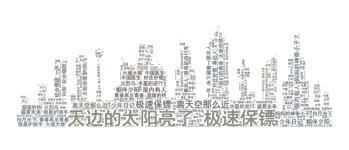

['牛王', '代号东方', '危情守护', '云霄之上', '三湾改编', '兴安岭上', '王良军长', '让这首歌作证', '烽火正年少', '牛王', '代号东方', '危情守护', '云霄之上', '三湾改编', '兴安岭上', '王良军长', '让这首歌作证', '烽火正年少', '牛王', '代号东方', '危情守护', '云霄之上', '三湾改编', '兴安岭上', '王良军长', '让这首歌作证', '烽火正年少', '牛王', '代号东方', '危情守护', '云霄之上', '三湾改编', '兴安岭上', '王良军长', '让这首歌作证', '烽火正年少', '牛王', '代号东方', '危情守护', '云霄之上', '三湾改编', '兴安岭上', '王良军长', '让这首歌作证', '烽火正年少', '格桑', '生死火线', '隐蔽战线', '红军挺进师', '三湾改编', '鄂伦春', '王良', '中国之命运', '报童', '格桑', '生死火线', '隐蔽战线', '红军挺进师', '三湾改编', '鄂伦春', '王良', '中国之命运', '报童', '格桑', '生死火线', '隐蔽战线', '红军挺进师', '三湾改编', '鄂伦春', '王良', '中国之命运', '报童', '格桑', '生死火线', '隐蔽战线', '红军挺进师', '三湾改编', '鄂伦春', '王良', '中国之命运', '报童', '格桑', '生死火线', '隐蔽战线', '红军挺进师', '三湾改编', '鄂伦春', '王良', '中国之命运', '报童', '山东', '民族', '支援', '人民', '比赛', '参加', '赢得', '兄弟', '讴歌', '祁连山', '秘密', '党员', '穿越', '生死', '上海', '重创', '工作', '火线', '出卖', '组织', '战线', '开展', '行径', '谍战', '维护', '遏制', '情报工作', '保家卫国', '重庆', '顽固派', '挺进', '了为', '集结', '争取', '战斗', '完成', '失联', '转移', '部队', '威胁', '历史', '时期', '解决', '回答', '置于', '在建', '探索', '初创', '事件',

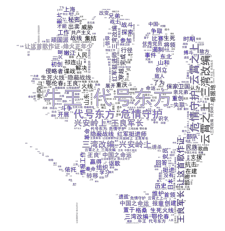

['陈真', '功夫阿暿', '鱼妖志', '醒狮衙门之赈灾贪腐案', '醒狮衙门之狼牙箭镞失踪案', '酒人传奇', '战火中的雕像', '陈真', '功夫阿暿', '鱼妖志', '醒狮衙门之赈灾贪腐案', '醒狮衙门之狼牙箭镞失踪案', '酒人传奇', '战火中的雕像', '陈真', '功夫阿暿', '鱼妖志', '醒狮衙门之赈灾贪腐案', '醒狮衙门之狼牙箭镞失踪案', '酒人传奇', '战火中的雕像', '陈真', '功夫阿暿', '鱼妖志', '醒狮衙门之赈灾贪腐案', '醒狮衙门之狼牙箭镞失踪案', '酒人传奇', '战火中的雕像', '陈真', '功夫阿暿', '鱼妖志', '醒狮衙门之赈灾贪腐案', '醒狮衙门之狼牙箭镞失踪案', '酒人传奇', '战火中的雕像', '陈真传奇', '舞女', '大理寺少卿薛杨', '醒狮衙门', '谛听处', '酒魂', '铜像传奇', '陈真传奇', '舞女', '大理寺少卿薛杨', '醒狮衙门', '谛听处', '酒魂', '铜像传奇', '陈真传奇', '舞女', '大理寺少卿薛杨', '醒狮衙门', '谛听处', '酒魂', '铜像传奇', '陈真传奇', '舞女', '大理寺少卿薛杨', '醒狮衙门', '谛听处', '酒魂', '铜像传奇', '陈真传奇', '舞女', '大理寺少卿薛杨', '醒狮衙门', '谛听处', '酒魂', '铜像传奇', '愣头', '热血', '得到', '变成', '重情义', '规矩', '斧头帮', '帮主', '彩礼', '凑够', '同乡', '招惹', '后人', '销禁', '日商', '父母', '成为', '赞颂', '扬名', '荷叶', '发生', '水面', '案件', '芽儿', '上官', '凶手', '真凶', '浮出', '曲江', '命案', '案情', '调查', '直致', '案犯', '百姓', '受灾', '致使', '银两', '赈灾', '贪污', '边关', '军火', '调查', '安定', '齐国', '权力', '机关', '追回', '案犯', '被劫', '文化', '时间跨度', '内战', '解放', '整整', '传奇', '情仇', '恩怨', '奋斗', '创业', '预算', '抵达', '应邀', '祠

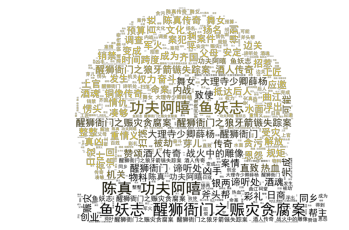

['生死权杖', '燃野少年的天空', '皮皮鲁与鲁西西之罐头小人', '48小时', '雪岭猎人传说', '图兰朵：魔咒缘起', '生死权杖', '燃野少年的天空', '皮皮鲁与鲁西西之罐头小人', '48小时', '雪岭猎人传说', '图兰朵：魔咒缘起', '生死权杖', '燃野少年的天空', '皮皮鲁与鲁西西之罐头小人', '48小时', '雪岭猎人传说', '图兰朵：魔咒缘起', '生死权杖', '燃野少年的天空', '皮皮鲁与鲁西西之罐头小人', '48小时', '雪岭猎人传说', '图兰朵：魔咒缘起', '生死权杖', '燃野少年的天空', '皮皮鲁与鲁西西之罐头小人', '48小时', '雪岭猎人传说', '图兰朵：魔咒缘起', '贝尔格莱德', '接力马拉松', '鲁西西与皮皮鲁', '48小时', '雪域之恋', '三色镯', '贝尔格莱德', '接力马拉松', '鲁西西与皮皮鲁', '48小时', '雪域之恋', '三色镯', '贝尔格莱德', '接力马拉松', '鲁西西与皮皮鲁', '48小时', '雪域之恋', '三色镯', '贝尔格莱德', '接力马拉松', '鲁西西与皮皮鲁', '48小时', '雪域之恋', '三色镯', '贝尔格莱德', '接力马拉松', '鲁西西与皮皮鲁', '48小时', '雪域之恋', '三色镯', '父亲', '姑娘', '塞国', '升天', '完成', '逃出', '解决', '危机', '结果', '发现', '结识', '懂得', '青春', '成长', '家境', '性格', '没有', '收留', '家庭', '学校', '发生', '小人', '双胞胎', '兄妹', '罐头', '生活', '变化', '发现', '器材', '航空', '澳门', '联合', '保卫', '广州', '镜湖', '委托', '会长', '抢夺', '电影', '表达', '雪域', '旅程', '人类', '故事', '展开', '美丽', '动物', '妻子', '猜错', '处死', '卷入', '图兰朵', '性格', '答题', '不想', '变得', '正义', '力量']


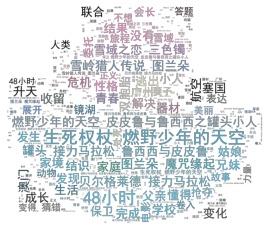

['东北警察故事', '怒火·重案', '不速来客', '猎盗者之彼岸花', '东北警察故事', '怒火·重案', '不速来客', '猎盗者之彼岸花', '东北警察故事', '怒火·重案', '不速来客', '猎盗者之彼岸花', '东北警察故事', '怒火·重案', '不速来客', '猎盗者之彼岸花', '东北警察故事', '怒火·重案', '不速来客', '猎盗者之彼岸花', '地下赌局', '绝命追捕', '非法交易', '惊天大阴谋', '地下赌局', '绝命追捕', '非法交易', '惊天大阴谋', '地下赌局', '绝命追捕', '非法交易', '惊天大阴谋', '地下赌局', '绝命追捕', '非法交易', '惊天大阴谋', '地下赌局', '绝命追捕', '非法交易', '惊天大阴谋', '犯罪', '出现', '计划', '获利', '公安民警', '企图', '休假', '了解', '操纵', '打掉', '警方', '警察', '澳门', '失败', '劝阻', '革职', '徒弟', '发生', '查案', '发现', '试图', '制服', '恶人', '凶手', '目击', '重拾', '行窃', '旧业', '选择', '犯罪团伙', '教授', '被盗', '破获', '文物', '警局', '解救', '女警', '故事', '大案', '警察']


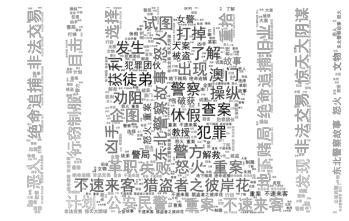

In [ ]:
ls_img = []
for idx, row in df_genre_sorted[:5].iterrows():
  ls_kw = row['片名']*5 + row['预测片名']*5 + row['kw']
  print(ls_kw)
  label = row['genre']
  fn_img = df_label2image.loc[df_label2image.label == label, 'fn'].iloc[0]
  generate_word_image(ls_words=ls_kw, img_name=fn_img)
  fn = path_img + '/ChinaFilm_NewReleases_Overview_' + \
    fn_img.split('.')[0] + '_'  + str_date_curr_release + '.png'
  ls_img.append(fn)

# [7] Generate Article

##[7.1] T1 标题：影片的前世今生

In [ ]:
# Title
T1 = '~{}月新片的前世今生~{}'.format(dt_curr_release.month, dt_curr_release.year)
T1

'~8月新片的前世今生~2021'

##[7.2] P1 2021年7月13日,又一批电影历经千辛万苦获得了公映许可证。本次

In [ ]:
P1 = '\t'
P1 +='{Y}年{M}月{D}日,'.format(Y=dt_curr_release.year, M=dt_curr_release.month, D=dt_curr_release.day)
P1 += '又一批电影历经千辛万苦获得了公映许可证。'

P1 += '本次获领证的影片共计{}部，'.format(df_curr_releases.shape[0])
P1 += '距离备案到获取公映证平均超过{}年。'.format(round(df_view['备案至今'].apply(lambda x: float(x.lstrip('> ').rstrip(' 年'))).mean(),1))
P1 += '其中，改过名字的有{}部，'.format(df.loc[df_view['匹配片名'] == '',:].shape[0])
P1 += '换过第一出品单位的有{}部，'.format(df.loc[df_view['原备案单位'] == '',:].shape[0])
P1 += '修改后才通过备案的有{}部，'.format(df.loc[df_view['是否修改'] == '是',:].shape[0])
P1 += '题材排名前五的分别是{}'.format('、'.join(df_genre_sorted['genre'][:4]))
P1 += '和{}。'.format(df_genre_sorted['genre'][4:5].iloc[0])

if df_curr_releases.shape[0] - df_view.shape[0] > 0:
  P1 += '神秘到不留痕迹的有{}部，'.format(df_curr_releases.shape[0] - df_view.shape[0])
P1 += '瓜熟蒂落实属不易。'
P1 += '本期改片名与换第一出品方的项目尤为多，从侧面反应了这两年影视业受到的冲击。'
P1 += '由于疫情，目前影院的排片较为动荡，有获取了公映许可立刻上画的，'
P1 += '也有上几个批次积压的影片，愿9月、10月陆续恢复排片。'

print(P1) 

	2021年8月18日,又一批电影历经千辛万苦获得了公映许可证。本次获领证的影片共计53部，距离备案到获取公映证平均超过2.4年。其中，改过名字的有30部，换过第一出品单位的有35部，修改后才通过备案的有2部，题材排名前五的分别是都市、革命、传奇、其它和涉案。瓜熟蒂落实属不易。本期改片名与换第一出品方的项目尤为多，从侧面反应了这两年影视业受到的冲击。由于疫情，目前影院的排片较为动荡，有获取了公映许可立刻上画的，也有上几个批次积压的影片，愿9月、10月陆续恢复排片。


##[7.3] P2 怀胎最久的影片是《红船》,从

In [ ]:
P2 = '\t'
P2 += '怀胎最久的影片是《{}》,'.format(df_view.iloc[0]['片名'])
P2 += '从备案到获得公映证超过{}年，'.format(df_view.iloc[0]['备案至今'].lstrip('> ').rstrip(' 年'))
P2 += '名字从《{}》进化成了《{}》，'.format(df_view.iloc[0]['匹配片名'], df_view.iloc[0]['片名'])
P2 += '第一出品方历经了{},最终由{}接棒。'.format(df_view.iloc[0]['原备案单位'], df_view.iloc[0]['第一出品单位'])
ls_choices = ['美好', '胜利', '牛逼']
#P2 += '坚持就是{}。'.format(ls_choices[random.randint(0,len(ls_choices)-1)])

print(P2)

	怀胎最久的影片是《相伴夕阳》,从备案到获得公映证超过7.9年，名字从《老伴》进化成了《相伴夕阳》，第一出品方历经了北京白鹭国际影视文化传媒有限公司,最终由电影频道节目中心接棒。


## [7.4] P3 同样坚守的还有...

In [ ]:
ls_name_3plus_year = df_view.loc[df_view['备案至今'].apply(lambda x: float(x.lstrip('> ').rstrip(' 年')))>3, '片名'].tolist()[1:]
ls_name_3plus_year = ['《'+ name + '》' for name in ls_name_3plus_year]
P3 = "\t"
P3 += '坚守了3年以上的影片还有{}。'.format('、'.join(ls_name_3plus_year))

print(P3)

	坚守了3年以上的影片还有《酒人传奇》、《图兰朵：魔咒缘起》、《长翅膀的红舞鞋》、《离天空那么近》、《让这首歌作证》、《水星的逆行》、《生死权杖》、《日常幻想指南》、《好还好借》、《青春再见青春》。


## [7.5] P4 上市公司相关

In [ ]:
# 本批次中与上市影视公司关联的项目有
info_public_film_co = pd.read_csv('/content/drive/MyDrive/Github/Content/tools/articles/reference/info_public_film_co.csv', index_col=0, encoding='utf-8-sig')
ls = info_public_film_co['公司简称'].apply(eval).sum()
pat_public = '|'.join(ls)
pat_public += '|阿里|腾讯|爱奇艺|英皇|寰亚|银都|美亚|大盛|儒意|灿星|横店'
df_focus = df_view.loc[df_view['第一出品单位'].str.contains(pat_public, regex=True)]
df_focus = df_focus[df_focus['片名'] != '顺子加油']
df_focus

In [ ]:
idx_remove = [33]
df_focus_narrowed = df_focus[~df_focus.index.isin(idx_remove)]

In [ ]:
P4 = '\t'
P4 += '本批次中，大数据分析识别出{}部上市影视公司关联项目，'.format(df_focus.shape[0])
P4 += '占比{}%。'.format(round( (df_focus.shape[0]/(df_view.shape[0]-1)*100), 2 ) )
P4 += '结合题材与出品方实力，慷田AI聚焦关注以下项目，题材类型包括了{}。'.format(
    '、'.join(df_focus_narrowed.genre.unique()))

print(P4)

	本批次中，大数据分析识别出5部上市影视公司关联项目，占比9.62%。结合题材与出品方实力，慷田AI聚焦关注以下项目，题材类型包括了涉案、都市。


##[7.6] P5 按题材展示词云图

In [ ]:
P5 = '\t'
P5 = '看图了解这期推出的电影都讲了什么。'

print(P5)

看图了解这期推出的电影都讲了什么。


## [7.7] 指向电影官网

In [ ]:
#####
E1 = '\n\n'
E1 += '\t'
E1 += '慷田AI结合自主调研及多方大数据比对，通过分析、建模，提炼关键信息。'
E1 += '公映许可证公示信息来自中国国家电影局 China Film Administration, 官方网址 '
E1 += ' http://www.chinafilm.gov.cn/chinafilm 。\n'
E1 += '\t本期慷田AI影片信息汇总：'

print(E1)



	慷田AI结合自主调研及多方大数据比对，通过分析、建模，提炼关键信息。公映许可证公示信息来自中国国家电影局 China Film Administration, 官方网址  http://www.chinafilm.gov.cn/chinafilm 。
	本期慷田AI影片信息汇总：


In [ ]:
 df_view['片名'].to_numpy()[0:5]

array(['相伴夕阳', '酒人传奇', '图兰朵：魔咒缘起', '长翅膀的红舞鞋', '离天空那么近'], dtype=object)

## [7.8] S0 生成摘要

In [ ]:
S0 = '{}月新片{}部，'.format(dt_curr_release.month, df_curr_releases.shape[0])
S0 += '平均孕期超{}年，'.format(round(df_view['备案至今'].apply(lambda x: float(x.lstrip('> ').rstrip(' 年'))).mean(),1))
S0 += '改名的{}部，'.format(df.loc[df_view['匹配片名'] == '',:].shape[0])
S0 += '换主的{}部，'.format(df.loc[df_view['原备案单位'] == '',:].shape[0])
S0 += '题材集中在{}'.format('、'.join(df_genre_sorted['genre'][:4]))
S0 += '和{}。'.format(df_genre_sorted['genre'][4:5].iloc[0])
S0 += '慷田AI聚焦'
focus = ['《'+ name + '》' for name in df_focus_narrowed['片名'].to_numpy()]
S0 += '{}'.format('、'.join(focus))
S0 += '…'

print(S0)

8月新片53部，平均孕期超2.4年，改名的30部，换主的35部，题材集中在都市、革命、传奇、其它和涉案。慷田AI聚焦《怒火·重案》、《妈妈的神奇小子》、《盛夏未来》、《大城大楼》…


# [5] Output Word Doc

## [5.1] Install Docx Lib

In [ ]:
%%capture
!pip install python-docx
!pip install lxml
from docx import Document
from docx.shared import Inches
#from docx.text.parargaph import Paragraph

from docx.shared import Pt

## Write to docx

In [ ]:
path_doc = '/content/drive/MyDrive/Github/Content/tools/articles/docx'
path_img = '/content/drive/MyDrive/Github/Content/tools/articles/img'

doc = Document()
doc.core_properties.title = 'ChinaFilm_NewReleases_Overview_' + str_date_curr_release
style = doc.styles['Normal']
font = style.font
font.name = 'simhei'
font.size = Pt(12)

doc.add_heading(T1, 0)

p = doc.add_paragraph(S0, style='Intense Quote')

doc.add_paragraph(P1)

doc.add_picture(path_img + '/posters/' + '妈妈的神奇小子.png', width =Inches(6))

doc.add_paragraph(P2)

doc.add_paragraph(P3)

doc.add_paragraph(P4)

table = doc.add_table(rows=1, cols=1, style='Light List Accent 4')
i = 1
for _, row in df_focus_narrowed.iterrows():
  row_cells = table.add_row().cells
  row_cells[0].text = '[' + str(i) + ']' + '《'.format(i) + row['片名'] + '》'
  i += 1

doc.add_paragraph(P5)
for genre, n, path in zip(df_genre_sorted['genre'][0:5].tolist(), 
                       df_genre_sorted['数量'][0:5].tolist(),
                       ls_img):
  doc.add_heading(genre + str(n) + '部')
  doc.add_picture(path, width =Inches(6))

doc.add_paragraph(E1)

table = doc.add_table(rows=1, cols=1, style='Light List Accent 4')
i = 1
for _, row in df_view.iterrows():
  row_cells = table.add_row().cells
  row_cells[0].text = '[' + str(i) + ']' + '《'.format(i) + row['片名'] + '》'
  if row['匹配片名'] != '':
    row_cells[0].text += ' (原备案名《{}》)'.format(row['匹配片名'])

  row_cells = table.add_row().cells
  row_cells[0].text = '编剧: ' + row['编剧'] 
  
  row_cells = table.add_row().cells
  row_cells[0].text = '距离备案 ' + row['备案至今']
  if row['是否修改'] == '是':
    row_cells[0].text += ', 修改后通过备案'

  row_cells = table.add_row().cells
  row_cells[0].text = '第一出品单位: ' + row['第一出品单位']
  if row['原备案单位'] != '': 
    row_cells = table.add_row().cells
    row_cells[0].text = '原备案单位：{}'.format(row['原备案单位'])

  row_cells = table.add_row().cells
  row_cells[0].text = row['梗概'].lstrip('\w+')

  row_cells = table.add_row().cells
  row_cells[0].text = ''
  i+=1


doc.save(path_doc + '/ChinaFilm_NewReleases_Overview_' + str_date_curr_release +'.docx' )

NameError: ignored